# Zero-Shot Classification using CLAP Models

Embeddings used in these experiments are extracted in the extract_embeddings.ipynb notebook. Each experiment is executed on MSCLAP and LAION CLAP.

Experiments:
1. k-fold evaluation. Accuracy and average precision is reported. The results for each fold are averaged over 1k calculations. The experiment is repeated with and without overlapping samples between folds, comprising 200 and 17 folds respectively. 
2. Based on the inspection of probabilities and top 3 class choices, classification errors are plausible errors for human labelers to make. Misclassified audio files are replaced by the 2nd and 3rd choice, in addition to a cascading version where errors after 2nd-choice substitution are replaced by the 3rd choice.

In [51]:
from msclap import CLAP
import laion_clap
import json
import pandas as pd
import numpy as np
from utils.dataset import DatasetUCS
import torch
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import configs.graphics_settings as graphics_settings
import random
import IPython.display as ipd
from sklearn.metrics import accuracy_score, average_precision_score, recall_score, precision_score, f1_score, ConfusionMatrixDisplay
from utils.experiment_logger import ExperimentLogger
from utils.set_torch_device import set_torch_device
from utils.seed_everything import seed_everything
from utils.evaluation_utils import k_fold_zs_predict, k_fold_zs_evaluation, load_embeddings_from_disk

In [4]:
# Load Testing Set
with open ('configs/kfold17-zero_shot.json', 'r') as f:
    settings_kfold17 = json.load (f)

with open ('configs/kfold200-zero_shot.json', 'r') as f:
    settings_kfold200 = json.load (f)

device, _ = set_torch_device()

In [5]:
# Load models
msclap_model = CLAP(version = '2023', use_cuda=True) # version can be 2022 or 2023
laion_clap_model = laion_clap.CLAP_Module(enable_fusion=False)
laion_clap_model.load_ckpt()

Load our best checkpoint in the paper.
The checkpoint is already downloaded
Load Checkpoint...
logit_scale_a 	 Loaded
logit_scale_t 	 Loaded
audio_branch.spectrogram_extractor.stft.conv_real.weight 	 Loaded
audio_branch.spectrogram_extractor.stft.conv_imag.weight 	 Loaded
audio_branch.logmel_extractor.melW 	 Loaded
audio_branch.bn0.weight 	 Loaded
audio_branch.bn0.bias 	 Loaded
audio_branch.patch_embed.proj.weight 	 Loaded
audio_branch.patch_embed.proj.bias 	 Loaded
audio_branch.patch_embed.norm.weight 	 Loaded
audio_branch.patch_embed.norm.bias 	 Loaded
audio_branch.layers.0.blocks.0.norm1.weight 	 Loaded
audio_branch.layers.0.blocks.0.norm1.bias 	 Loaded
audio_branch.layers.0.blocks.0.attn.relative_position_bias_table 	 Loaded
audio_branch.layers.0.blocks.0.attn.qkv.weight 	 Loaded
audio_branch.layers.0.blocks.0.attn.qkv.bias 	 Loaded
audio_branch.layers.0.blocks.0.attn.proj.weight 	 Loaded
audio_branch.layers.0.blocks.0.attn.proj.bias 	 Loaded
audio_branch.layers.0.blocks.0.norm2.we

In [6]:
k_fold_200_audio_embeddings_laion = load_embeddings_from_disk(settings_kfold200["laion_audio_embeddings"])
k_fold_200_audio_embeddings_msclap = load_embeddings_from_disk(settings_kfold200["msclap_audio_embeddings"])
k_fold_17_audio_embeddings_laion = load_embeddings_from_disk(settings_kfold17["laion_audio_embeddings"]) 
k_fold_17_audio_embeddings_msclap = load_embeddings_from_disk(settings_kfold17["msclap_audio_embeddings"])

## Single Example Evaluation

This block outlines the process used to make a single prediction and inspect probabilities.

Predicted Class (Best Prediction): beeps at index 6
Predicted Classes (Best Match To Worst): beeps, user interface, alarms
True Class: alarms at index 2


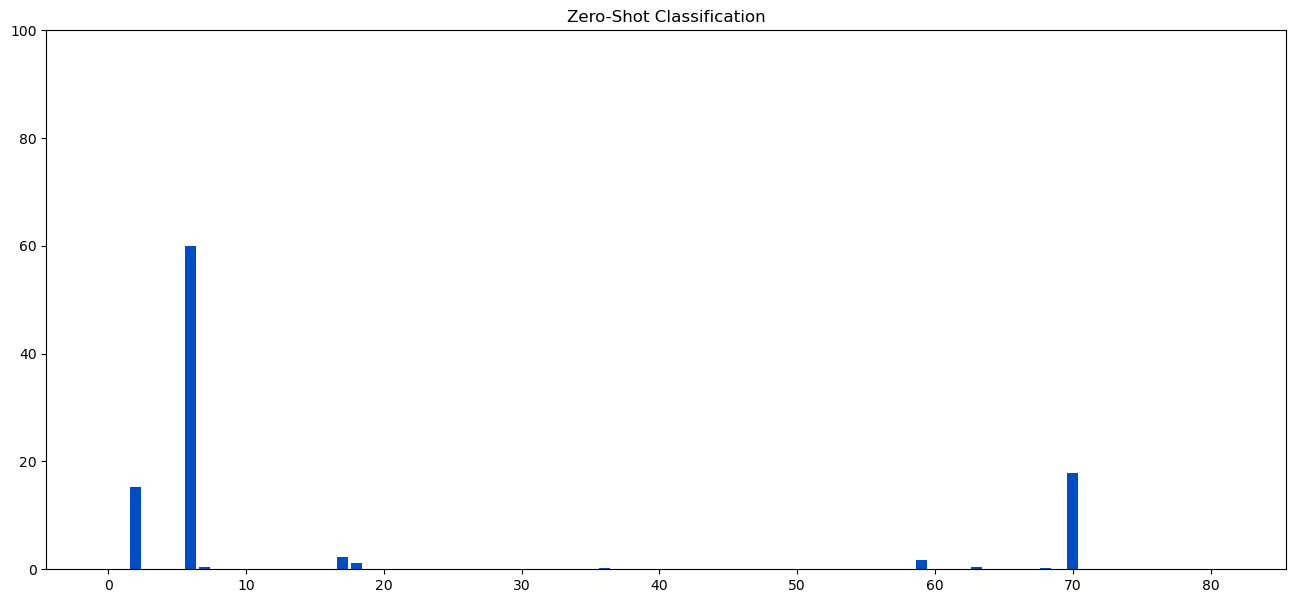

In [18]:
with open (settings_kfold200['class_converter'], 'r') as f:
    ucs_classes = json.load (f)

k_fold_embeddings = k_fold_200_audio_embeddings_msclap
# Sample randomly from the dataset.
fold_idx = random.randint(0, k_fold_embeddings.size()[0]-1)
sample_idx = random.randint(0, k_fold_embeddings.size()[1]-1)
df = pd.read_csv(settings_kfold200["ground_truth"] + f"zs_fold_with_overlap_{fold_idx+1}.csv") # not 0-indexed
dataset = DatasetUCS(df, settings_kfold200, device=device, return_type='path')
path, _, class_name = dataset[sample_idx]
label_embeddings = msclap_model.get_text_embeddings(list(ucs_classes['class_to_int'].keys()))
current_emb = k_fold_embeddings[fold_idx][sample_idx]
#current_emb = msclap_model.get_audio_embeddings([path])
similarities = msclap_model.compute_similarity(current_emb, torch.Tensor(label_embeddings).to(device))
similarities = similarities.detach()
probs = torch.softmax(similarities.view(1, -1), dim=1).detach().flatten() * 100
probs = probs.cpu()
pred_labels = torch.topk(probs, k=3).indices
str_labels = []
for label in pred_labels:
    str_labels.append(f"{label}")

idx = torch.argmax(probs)
idx = f"{idx}"
print(f"Predicted Class (Best Prediction): {ucs_classes['int_to_class'][idx]} at index {idx}")
print(f"Predicted Classes (Best Match To Worst): {ucs_classes['int_to_class'][str_labels[0]]}, {ucs_classes['int_to_class'][str_labels[1]]}, {ucs_classes['int_to_class'][str_labels[2]]}")
print(f"True Class: {class_name} at index {ucs_classes['class_to_int'][class_name]}")

# Plot probabilities
fig = plt.figure(2, figsize=(16, 7))
ax = fig.subplots(1)
ax.set_title("Zero-Shot Classification")
ax.set_ylim(0, 100)
ax.bar(range(len(probs)), height=probs, color=graphics_settings.primary_color)

ipd.Audio(path)

# K-Fold Zero Shot Classification



In [7]:
seed_everything(1337)
experiment_logger = ExperimentLogger("logs/", "unnamed_experiment")

unnamed_experiment


In [8]:
msclap_k_fold_17_gold_labels, msclap_k_fold_17_pred_labels = k_fold_zs_predict(settings_kfold17, k_fold_17_audio_embeddings_msclap, msclap_model.get_text_embeddings, msclap_model.compute_similarity, device=device)
msclap_k_fold_17_accuracy, msclap_k_fold_17_precision, msclap_k_fold_17_recall, msclap_k_fold_17_f1, msclap_k_fold_17_ap = k_fold_zs_evaluation(msclap_k_fold_17_gold_labels, msclap_k_fold_17_pred_labels)

print(f"MSCLAP Accuracy Score: {msclap_k_fold_17_accuracy}")
print(f"MSCLAP Average Precision Score: {msclap_k_fold_17_ap}")
print(f"MSCLAP Precision Score: {msclap_k_fold_17_precision}")
print(f"MSCLAP Recall Score: {msclap_k_fold_17_recall}")
print(f"MSCLAP F1 Score: {msclap_k_fold_17_f1}")

laion_k_fold_17_gold_labels, laion_k_fold_17_pred_labels = k_fold_zs_predict(settings_kfold17, k_fold_17_audio_embeddings_laion, laion_clap_model.get_text_embedding, torch.cosine_similarity, device=device)
laion_k_fold_17_accuracy, laion_k_fold_17_precision, laion_k_fold_17_recall, laion_k_fold_17_f1, laion_k_fold_17_ap = k_fold_zs_evaluation(laion_k_fold_17_gold_labels, laion_k_fold_17_pred_labels)

print(f"LAION Accuracy Score: {laion_k_fold_17_accuracy}")
print(f"LAION Average Precision Score: {laion_k_fold_17_ap}")
print(f"LAION Precision Score: {laion_k_fold_17_precision}")
print(f"LAION Recall Score: {laion_k_fold_17_recall}")
print(f"LAION F1 Score: {laion_k_fold_17_f1}")

experiment_logger.experiment_name = "kfold17-zero_shot"
results = {
    "msclap" : {
        "accuracy" : msclap_k_fold_17_accuracy,
        "average_precision" : msclap_k_fold_17_ap,
        "recall" : msclap_k_fold_17_recall,
        "precision" : msclap_k_fold_17_precision,
        "f1" : msclap_k_fold_17_f1
    },
    "laion" : {
        "accuracy" : laion_k_fold_17_accuracy,
        "average_precision" : laion_k_fold_17_ap,
        "recall" : laion_k_fold_17_recall,
        "precision" : laion_k_fold_17_precision,
        "f1" : laion_k_fold_17_f1
    }
}

experiment_logger.log_results(results)
experiment_logger.save_log()

100%|██████████| 17/17 [00:05<00:00,  2.96it/s]


MSCLAP Accuracy Score: 0.25199709513435004
MSCLAP Average Precision Score: 0.012177299627363396
MSCLAP Precision Score: 0.2554558114081962
MSCLAP Recall Score: 0.25199709513435004
MSCLAP F1 Score: 0.21977154613436553


100%|██████████| 17/17 [00:04<00:00,  4.12it/s]

LAION Accuracy Score: 0.21931735657225854
LAION Average Precision Score: 0.011412813390354687
LAION Precision Score: 0.22545928329332274
LAION Recall Score: 0.21664275466284072
LAION F1 Score: 0.19055179141529677


In [9]:
msclap_k_fold_200_gold_labels, msclap_k_fold_200_pred_labels = k_fold_zs_predict(settings_kfold200, k_fold_200_audio_embeddings_msclap, msclap_model.get_text_embeddings, msclap_model.compute_similarity, device=device)
msclap_k_fold_200_accuracy, msclap_k_fold_200_precision, msclap_k_fold_200_recall, msclap_k_fold_200_f1, msclap_k_fold_200_ap = k_fold_zs_evaluation(msclap_k_fold_200_gold_labels, msclap_k_fold_200_pred_labels)

print(f"MSCLAP Accuracy Score: {msclap_k_fold_200_accuracy}")
print(f"MSCLAP Average Precision Score: {msclap_k_fold_200_ap}")
print(f"MSCLAP Precision Score: {msclap_k_fold_200_precision}")
print(f"MSCLAP Recall Score: {msclap_k_fold_200_recall}")
print(f"MSCLAP F1 Score: {msclap_k_fold_200_f1}")

laion_k_fold_200_gold_labels, laion_k_fold_200_pred_labels = k_fold_zs_predict(settings_kfold200, k_fold_200_audio_embeddings_laion, laion_clap_model.get_text_embedding, torch.cosine_similarity, device=device)
laion_k_fold_200_accuracy, laion_k_fold_200_precision, laion_k_fold_200_recall, laion_k_fold_200_f1, laion_k_fold_200_ap = k_fold_zs_evaluation(laion_k_fold_200_gold_labels, laion_k_fold_200_pred_labels)

print(f"LAION Accuracy Score: {laion_k_fold_200_accuracy}")
print(f"LAION Average Precision Score: {laion_k_fold_200_ap}")
print(f"LAION Precision Score: {laion_k_fold_200_precision}")
print(f"LAION Recall Score: {laion_k_fold_200_recall}")
print(f"LAION F1 Score: {laion_k_fold_200_f1}")

experiment_logger.experiment_name = "kfold200-zero_shot"
results = {
    "msclap" : {
        "accuracy" : msclap_k_fold_200_accuracy,
        "average_precision" : msclap_k_fold_200_ap,
        "recall" : msclap_k_fold_200_recall,
        "precision" : msclap_k_fold_200_precision,
        "f1" : msclap_k_fold_200_f1
    },
    "laion" : {
        "accuracy" : laion_k_fold_200_accuracy,
        "average_precision" : laion_k_fold_200_ap,
        "recall" : laion_k_fold_200_recall,
        "precision" : laion_k_fold_200_precision,
        "f1" : laion_k_fold_200_f1
    }
}

experiment_logger.log_results(results)
experiment_logger.save_log()

100%|██████████| 200/200 [00:58<00:00,  3.44it/s]


MSCLAP Accuracy Score: 0.26654320987654323
MSCLAP Average Precision Score: 0.01472771779410438
MSCLAP Precision Score: 0.3107401820657017
MSCLAP Recall Score: 0.26654320987654323
MSCLAP F1 Score: 0.23735447066717857


100%|██████████| 200/200 [00:48<00:00,  4.11it/s]

LAION Accuracy Score: 0.23104938271604938
LAION Average Precision Score: 0.01025830237141868
LAION Precision Score: 0.24843351111542056
LAION Recall Score: 0.22823170731707318
LAION F1 Score: 0.20479072247756694


## Class-Merged kfold200
MSCLAP is pretty consistent regarding the classes it confuses, while LAION CLAP is more diffuse. Because MSCLAP also got a better accuracy score, this next section will report the change in accuracy when wrong predictions are replaced by the topk result, where k=2 or 3.

In [10]:
msclap_k_fold_200_gold_labels, msclap_k_fold_200_pred_labels = k_fold_zs_predict(
    settings_kfold200,
    k_fold_200_audio_embeddings_msclap, 
    msclap_model.get_text_embeddings, 
    msclap_model.compute_similarity, 
    device=device, 
    topk=3
    )

# Unpack topk predictions
k_1 = [row[0] for row in msclap_k_fold_200_pred_labels] # 1st Prediction
k_2 = [row[1] for row in msclap_k_fold_200_pred_labels] # 2nd Prediction
k_3 = [row[2] for row in msclap_k_fold_200_pred_labels] # 3rd Prediction

# Switch wrong predictions to 2nd and 3rd choice.
msclap_k_fold_200_pred_labels_topk2replaced = [topk_1 if topk_1 == label else topk_2 for label, topk_1, topk_2 in zip(msclap_k_fold_200_gold_labels, k_1, k_2)]
msclap_k_fold_200_pred_labels_topk3replaced = [topk_1 if topk_1 == label else topk_3 for label, topk_1, topk_3 in zip(msclap_k_fold_200_gold_labels, k_1, k_3)]
# Cascading version
msclap_k_fold_200_pred_labels_topk_cascade = [topk_2 if topk_2 == label else topk_3 for label, topk_2, topk_3 in zip(msclap_k_fold_200_gold_labels, msclap_k_fold_200_pred_labels_topk2replaced, k_3)]

# Evaluate
msclap_kfold200_accuracy_k2, msclap_kfold200_precision_k2, msclap_kfold200_recall_k2, msclap_kfold200_f1_k2, msclap_kfold200_ap_k2 = k_fold_zs_evaluation(msclap_k_fold_200_gold_labels, msclap_k_fold_200_pred_labels_topk2replaced)

print(f"MSCLAP Accuracy Score (Topk=2): {msclap_kfold200_accuracy_k2}")
print(f"MSCLAP Average Precision Score (Topk=2): {msclap_kfold200_ap_k2}")
print(f"MSCLAP Precision Score (Topk=2): {msclap_kfold200_precision_k2}")
print(f"MSCLAP Recall Score (Topk=2): {msclap_kfold200_recall_k2}")
print(f"MSCLAP F1 Score (Topk=2): {msclap_kfold200_f1_k2}")
print("\n")
msclap_kfold200_accuracy_k3, msclap_kfold200_precision_k3, msclap_kfold200_recall_k3, msclap_kfold200_f1_k3, msclap_kfold200_ap_k3 = k_fold_zs_evaluation(msclap_k_fold_200_gold_labels, msclap_k_fold_200_pred_labels_topk3replaced)

print(f"MSCLAP Accuracy Score (Topk=3): {msclap_kfold200_accuracy_k3}")
print(f"MSCLAP Average Precision Score (Topk=3): {msclap_kfold200_ap_k3}")
print(f"MSCLAP Precision Score (Topk=3): {msclap_kfold200_precision_k3}")
print(f"MSCLAP Recall Score (Topk=3): {msclap_kfold200_recall_k3}")
print(f"MSCLAP F1 Score (Topk=3): {msclap_kfold200_f1_k3}")
print("\n")
msclap_kfold200_accuracy_cascade, msclap_kfold200_precision_cascade, msclap_kfold200_recall_cascade, msclap_kfold200_f1_cascade, msclap_kfold200_ap_cascade = k_fold_zs_evaluation(msclap_k_fold_200_gold_labels, msclap_k_fold_200_pred_labels_topk_cascade)

print(f"MSCLAP Accuracy Score (Topk=2+3): {msclap_kfold200_accuracy_cascade}")
print(f"MSCLAP Average Precision Score (Topk=2+3): {msclap_kfold200_ap_cascade}")
print(f"MSCLAP Precision Score (Topk=2+3): {msclap_kfold200_precision_cascade}")
print(f"MSCLAP Recall Score (Topk=2+3): {msclap_kfold200_recall_cascade}")
print(f"MSCLAP F1 Score (Topk=2+3): {msclap_kfold200_f1_cascade}")

100%|██████████| 200/200 [01:01<00:00,  3.25it/s]


MSCLAP Accuracy Score (Topk=2): 0.3727160493827161
MSCLAP Average Precision Score (Topk=2): 0.014467130099295072
MSCLAP Precision Score (Topk=2): 0.39301143347508743
MSCLAP Recall Score (Topk=2): 0.372716049382716
MSCLAP F1 Score (Topk=2): 0.333434183132128


MSCLAP Accuracy Score (Topk=3): 0.3341358024691358
MSCLAP Average Precision Score (Topk=3): 0.013819001697517623
MSCLAP Precision Score (Topk=3): 0.35039978605040867
MSCLAP Recall Score (Topk=3): 0.3341358024691358
MSCLAP F1 Score (Topk=3): 0.30745164335787034


MSCLAP Accuracy Score (Topk=2+3): 0.44030864197530867
MSCLAP Average Precision Score (Topk=2+3): 0.013925449236643203
MSCLAP Precision Score (Topk=2+3): 0.4480612675644248
MSCLAP Recall Score (Topk=2+3): 0.4403086419753086
MSCLAP F1 Score (Topk=2+3): 0.3984834196295523


In [11]:
laion_k_fold_200_gold_labels, laion_k_fold_200_pred_labels = k_fold_zs_predict(
    settings_kfold200,
    k_fold_200_audio_embeddings_laion, 
    laion_clap_model.get_text_embedding, 
    torch.cosine_similarity, 
    device=device, 
    topk=3
    )

# Unpack topk predictions
k_1 = [row[0] for row in laion_k_fold_200_pred_labels] # 1st Prediction
k_2 = [row[1] for row in laion_k_fold_200_pred_labels] # 2nd Prediction
k_3 = [row[2] for row in laion_k_fold_200_pred_labels] # 3rd Prediction

# Switch wrong predictions to 2nd and 3rd choice.
laion_k_fold_200_pred_labels_topk2replaced = [topk_1 if topk_1 == label else topk_2 for label, topk_1, topk_2 in zip(laion_k_fold_200_gold_labels, k_1, k_2)]
laion_k_fold_200_pred_labels_topk3replaced = [topk_1 if topk_1 == label else topk_3 for label, topk_1, topk_3 in zip(laion_k_fold_200_gold_labels, k_1, k_3)]
# Cascading version
laion_k_fold_200_pred_labels_topk_cascade = [topk_2 if topk_2 == label else topk_3 for label, topk_2, topk_3 in zip(laion_k_fold_200_gold_labels, laion_k_fold_200_pred_labels_topk2replaced, k_3)]

# Evaluate
laion_kfold200_accuracy_k2, laion_kfold200_precision_k2, laion_kfold200_recall_k2, laion_kfold200_f1_k2, laion_kfold200_ap_k2 = k_fold_zs_evaluation(laion_k_fold_200_gold_labels, laion_k_fold_200_pred_labels_topk2replaced)

print(f"LAION CLAP Accuracy Score (Topk=2): {laion_kfold200_accuracy_k2}")
print(f"LAION CLAP Average Precision Score (Topk=2): {laion_kfold200_ap_k2}")
print(f"LAION CLAP Precision Score (Topk=2): {laion_kfold200_precision_k2}")
print(f"LAION CLAP Recall Score (Topk=2): {laion_kfold200_recall_k2}")
print(f"LAION CLAP F1 Score (Topk=2): {laion_kfold200_f1_k2}")
print("\n")
laion_kfold200_accuracy_k3, laion_kfold200_precision_k3, laion_kfold200_recall_k3, laion_kfold200_f1_k3, laion_kfold200_ap_k3 = k_fold_zs_evaluation(laion_k_fold_200_gold_labels, laion_k_fold_200_pred_labels_topk3replaced)

print(f"LAION CLAP Accuracy Score (Topk=3): {laion_kfold200_accuracy_k3}")
print(f"LAION CLAP Average Precision Score (Topk=3): {laion_kfold200_ap_k3}")
print(f"LAION CLAP Precision Score (Topk=3): {laion_kfold200_precision_k3}")
print(f"LAION CLAP Recall Score (Topk=3): {laion_kfold200_recall_k3}")
print(f"LAION CLAP F1 Score (Topk=3): {laion_kfold200_f1_k3}")
print("\n")
laion_kfold200_accuracy_cascade, laion_kfold200_precision_cascade, laion_kfold200_recall_cascade, laion_kfold200_f1_cascade, laion_kfold200_ap_cascade = k_fold_zs_evaluation(laion_k_fold_200_gold_labels, laion_k_fold_200_pred_labels_topk_cascade)

print(f"LAION CLAP Accuracy Score (Topk=2+3): {laion_kfold200_accuracy_cascade}")
print(f"LAION CLAP Average Precision Score (Topk=2+3): {laion_kfold200_ap_cascade}")
print(f"LAION CLAP Precision Score (Topk=2+3): {laion_kfold200_precision_cascade}")
print(f"LAION CLAP Recall Score (Topk=2+3): {laion_kfold200_recall_cascade}")
print(f"LAION CLAP F1 Score (Topk=2+3): {laion_kfold200_f1_cascade}")

100%|██████████| 200/200 [00:49<00:00,  4.05it/s]


LAION CLAP Accuracy Score (Topk=2): 0.32271604938271603
LAION CLAP Average Precision Score (Topk=2): 0.01008021014218071
LAION CLAP Precision Score (Topk=2): 0.32735942779508
LAION CLAP Recall Score (Topk=2): 0.31878048780487805
LAION CLAP F1 Score (Topk=2): 0.29200991140498006


LAION CLAP Accuracy Score (Topk=3): 0.29055555555555557
LAION CLAP Average Precision Score (Topk=3): 0.010176699462444178
LAION CLAP Precision Score (Topk=3): 0.3003147604527816
LAION CLAP Recall Score (Topk=3): 0.2870121951219512
LAION CLAP F1 Score (Topk=3): 0.2688201645772102


LAION CLAP Accuracy Score (Topk=2+3): 0.38222222222222224
LAION CLAP Average Precision Score (Topk=2+3): 0.009902191150570581
LAION CLAP Precision Score (Topk=2+3): 0.3782624643290066
LAION CLAP Recall Score (Topk=2+3): 0.3775609756097561
LAION CLAP F1 Score (Topk=2+3): 0.3490745621296883


In [12]:
# Log Results
experiment_logger.experiment_name = "kfold200-zero_shot-topk"
results = {
    "msclap" : {
        "topk1" : {
            "accuracy" : msclap_k_fold_200_accuracy,
            "average_precision" : msclap_k_fold_200_ap,
            "recall" : msclap_k_fold_200_recall,
            "precision" : msclap_k_fold_200_precision,
            "f1" : msclap_k_fold_200_f1
        },
        "topk2" : {
            "accuracy" : msclap_kfold200_accuracy_k2,
            "average_precision" : msclap_kfold200_ap_k2,
            "recall" : msclap_kfold200_recall_k2,
            "precision" : msclap_kfold200_precision_k2,
            "f1" : msclap_kfold200_f1_k2
        },
        "topk3" : {
            "accuracy" : msclap_kfold200_accuracy_k3,
            "average_precision" : msclap_kfold200_ap_k3,
            "recall" : msclap_kfold200_recall_k3,
            "precision" : msclap_kfold200_precision_k3,
            "f1" : msclap_kfold200_f1_k3
        },
        "cascade" : {
            "accuracy" : msclap_kfold200_accuracy_cascade,
            "average_precision" : msclap_kfold200_ap_cascade,
            "recall" : msclap_kfold200_recall_cascade,
            "precision" : msclap_kfold200_precision_cascade,
            "f1" : msclap_kfold200_f1_cascade
        },
    },
    "laion" : {
        "topk1" : {
            "accuracy" : laion_k_fold_200_accuracy,
            "average_precision" : laion_k_fold_200_ap,
            "recall" : laion_k_fold_200_recall,
            "precision" : laion_k_fold_200_precision,
            "f1" : laion_k_fold_200_f1
        },
        "topk2" : {
            "accuracy" : laion_kfold200_accuracy_k2,
            "average_precision" : laion_kfold200_ap_k2,
            "recall" : laion_kfold200_recall_k2,
            "precision" : laion_kfold200_precision_k2,
            "f1" : laion_kfold200_f1_k2
        },
        "topk3" : {
            "accuracy" : laion_kfold200_accuracy_k3,
            "average_precision" : laion_kfold200_ap_k3,
            "recall" : laion_kfold200_recall_k3,
            "precision" : laion_kfold200_precision_k3,
            "f1" : laion_kfold200_f1_k3
        },
        "cascade" : {
            "accuracy" : laion_k_fold_200_accuracy,
            "average_precision" : laion_k_fold_200_ap,
            "recall" : laion_k_fold_200_recall,
            "precision" : laion_k_fold_200_precision,
            "f1" : laion_kfold200_f1_cascade
        }
    }
}

experiment_logger.log_results(results)
experiment_logger.save_log()

In [114]:
# Prepare top predictions for plotting. Unpack.
laion_k_fold_200_pred_labels_topk1 = [row[0] for row in laion_k_fold_200_pred_labels] # 1st Prediction
msclap_k_fold_200_pred_labels_topk1 = [row[0] for row in msclap_k_fold_200_pred_labels] # 1st Prediction

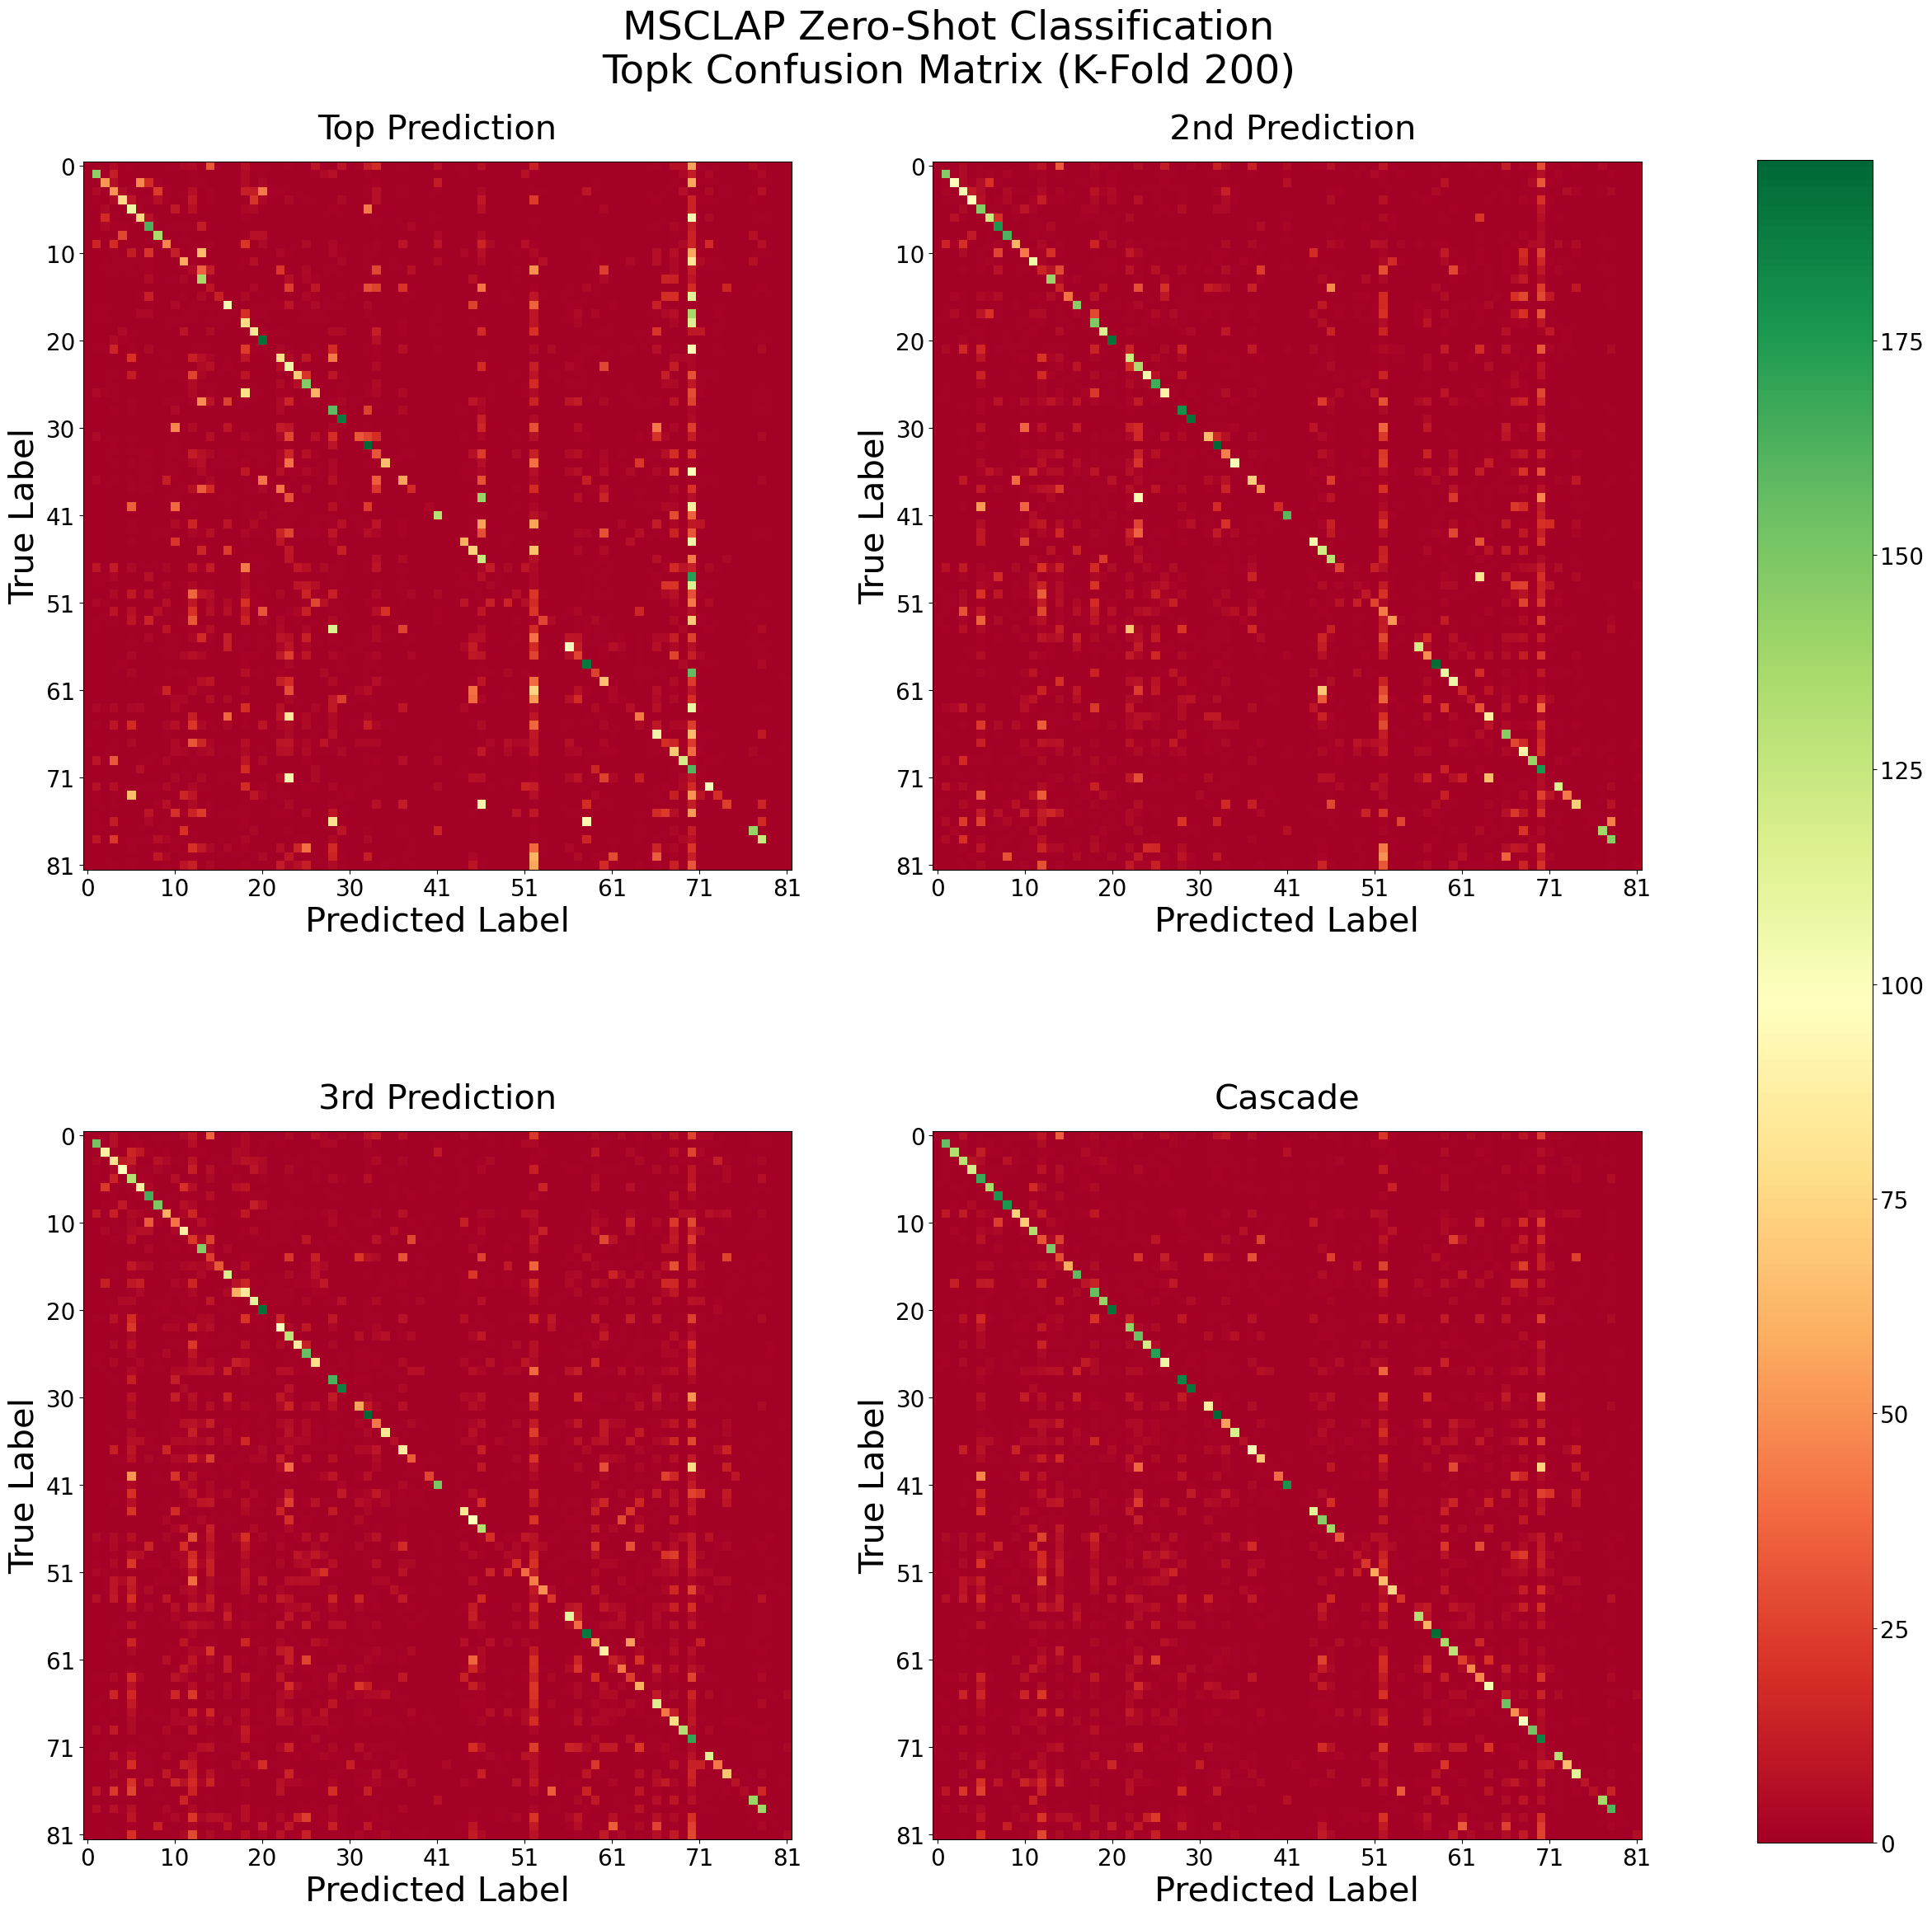

In [154]:
# Explort Confusion Matrix

fig, axes = plt.subplots(2, 2, figsize=(28,28))
fig.suptitle("MSCLAP Zero-Shot Classification\nTopk Confusion Matrix (K-Fold 200)", fontsize=35, y=0.925)
laion_plot_predictions = np.array([[laion_k_fold_200_pred_labels_topk1, laion_k_fold_200_pred_labels_topk2replaced],
                          [laion_k_fold_200_pred_labels_topk3replaced, laion_k_fold_200_pred_labels_topk_cascade]])
msclap_plot_predictions = np.array([[msclap_k_fold_200_pred_labels_topk1, msclap_k_fold_200_pred_labels_topk2replaced],
                          [msclap_k_fold_200_pred_labels_topk3replaced, msclap_k_fold_200_pred_labels_topk_cascade]])

ax_titles = [["Top Prediction", " 2nd Prediction"], ["3rd Prediction", "Cascade"]]

for i, ax in enumerate(axes[0]):
    for j, ax in enumerate(axes[1]):
        cmp = ConfusionMatrixDisplay.from_predictions(msclap_k_fold_200_gold_labels, msclap_plot_predictions[i, j], colorbar=False, include_values=False, cmap='RdYlGn', ax=axes[i, j])
        #cmp.plot(ax=axes[i, j], cmap='RdYlGn', include_values=False, colorbar=False)
        axes[i, j].set_title(f"{ax_titles[i][j]}", fontsize=30, pad=20)
        axes[i, j].set_xlabel("Predicted Label", fontsize=30)
        axes[i, j].set_ylabel("True Label",fontsize=30)
        axes[i, j].set_xticks(np.arange(0,81,10))
        axes[i, j].set_yticks(np.arange(0,81,10))
        axes[i, j].tick_params(axis='both', which='both', labelsize=20)
        axes[i, j].text(x=0.0, y=0.0, s="")


fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.13, 0.05, 0.729])
cbar = fig.colorbar(cmp.im_, cax=cbar_ax)
cbar.ax.tick_params(labelsize=20)

plt.savefig("kfold200_msclap_zero_shot_topk.png", dpi=300, bbox_inches='tight', transparent=False)

In [45]:
# Inspect which classes misclassified samples belong to.
ucs_classes['int_to_class']["61"]

'rope'